## Mode Solver

This tutorial shows how to use the mode solver plugin in tidy3d.

In [1]:
import numpy as np
import matplotlib.pylab as plt

import sys
sys.path.append('..')

import tidy3d as td
from tidy3d.constants import C_0

## Setup

We first set up the mode solver with information about our system.

We start by setting parameters

In [2]:
# size of simulation domain
Lx, Ly, Lz = 6, 6, 6
dl = .05

# waveguide information 
wg_width = 1.5
wg_height = 1.0
wg_permittivity = 4.0

# frequency we want to solve at (freq0)
wvl_um = 2.0
freq_hz = C_0 / wvl_um

Then we set up a simulation, in this case including a straight waveguide

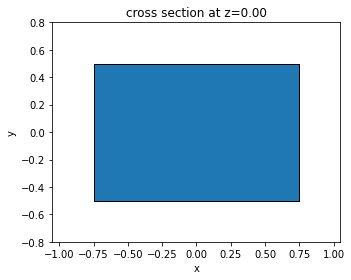

In [3]:
waveguide = td.Structure(
    geometry = td.Box(size=(wg_width, wg_height, Lz)),
    medium = td.Medium(permittivity=wg_permittivity)
)

sim = td.Simulation(
    size=(Lx, Ly, Lz),
    grid_size=(dl, dl, dl),
    pml_layers=(
        td.PMLLayer(num_layers=0),
        td.PMLLayer(num_layers=0),
        td.PMLLayer(num_layers=0),        
    ),
    structures=[waveguide],
)

im = waveguide.geometry.plot(z=0)

## Initialize Mode Solver

With our system defined, we can now create our mode solver.

We first need to specify on what plane we want to solve the modes using a `td.Box()` object.

In [4]:
plane = td.Box(
    center=(0,0,0),
    size=(Lx, Ly, 0)
)

Then we can initialize a `ModeSolver()` object to solve for the modes at frequency `freq` on plane `plane` in `sim`.

The mode solver will evaluate the complex-valued permittivity of `simulation` on `plane` at frequency `freq` and use this for the mode solver.

In [5]:
from tidy3d.plugins import ModeSolver

mode_solver = ModeSolver(
    simulation=sim,
    plane=plane,
    freq=freq_hz
)

## Define Mode

The goal of the mode solver is to determine a `td.Mode()` specification that can be used in your actual Tidy3d simulation.

We can define such a specification using

- `mode_index`: integer (return the `mode_index`-th result of the solver, generally this refers to the mode with the `mode_index`-th lowest effective index.

- `target_neff`: float, default=None, guess for the n_eff of the mode, if not specified, chooses the maximum real part of the refractive index in the cross section.

- `symmetry`: tuple of 2 integers, default=(0,0), with the first and second value being one of {0: no symmetry, 1: PMC (even), -1: PEC (odd)}.  These set the symmetry on the two axes of the plane.

- `num_pml`: tuple of 2 integers, default=(0,0) specifying how many pml layers to place on the two axes of the plane.

For example:

In [6]:
mode = td.Mode(
    mode_index=0, # fundamental mode?
    target_neff=None,
    symmetries=(0,0),
    num_pml=(0,0)
)

Once we have the mode specification, we can `solve` for the mode information using our `ModeSolver()` instance.

In [7]:
mode_info = mode_solver.solve(mode)

## Visualizing Mode Data

The `mode_info` object contains information about the effective index of the mode and the field profiles.

The effective index information can be accessed as follows.

In [8]:
n_eff = mode_info.n_eff
k_eff = mode_info.k_eff

print(f'found: n_eff = {n_eff:.2f}, k_eff = {k_eff:.2e}')

found: n_eff = 1.76, k_eff = 2.09e-17


The `mode_info.field_data` attribute is a `td.FieldData` instance that can be visualized and analyzed using the various methods provided by `FieldData` objects.

In [9]:
mode_info.field_data.data.coords

Coordinates:
  * x        (x) float64 -3.0 -2.95 -2.9 -2.85 -2.8 ... 2.8 2.85 2.9 2.95 3.0
  * y        (y) float64 -3.0 -2.95 -2.9 -2.85 -2.8 ... 2.8 2.85 2.9 2.95 3.0
  * z        (z) float64 0.0
  * f        (f) float64 1.499e+14

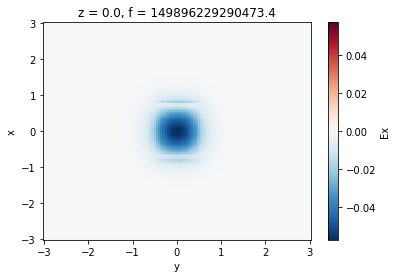

In [10]:
_ = mode_info.field_data.data.Ex.real.plot()

## Refining the Mode information

In typical settings, one would want to tweak the parameters in the `Mode` specification nd run again.

For example, if we wanted to find the next higher order mode, we can adjust `Mode.mode_index` and solve again.

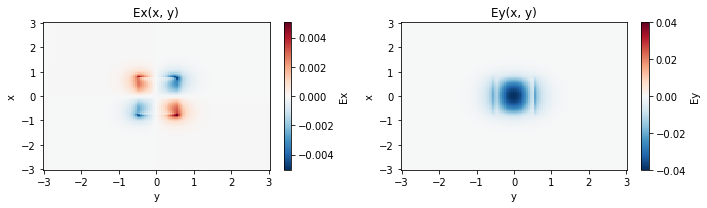

In [11]:
mode.mode_index=1
mode_info = mode_solver.solve(mode)
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
mode_info.field_data.data.Ex.real.plot(ax=ax1)
mode_info.field_data.data.Ey.real.plot(ax=ax2)
ax1.set_title('Ex(x, y)')
ax2.set_title('Ey(x, y)')
plt.show()

This looks like an Ey-dominant mode, if instead we wanted a higher order Ex-dominant mode, let's try again with `mode_index=3`.

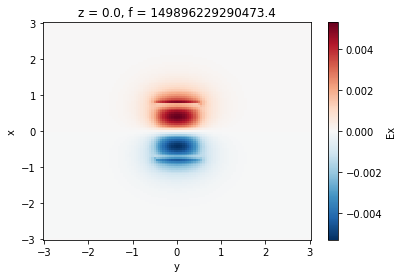

In [12]:
mode.mode_index = 3
mode_info = mode_solver.solve(mode)
_ = mode_info.field_data.data.Ex.real.plot()

## Exporting Results

This looks promising!

Now we may want to export this `Mode` specification to use in our main tidy3d script.

There are several ways to do this:

### As Mode
The `Mode` object used in the `ModeSolver` can be used directly to define a `ModeSource` or `ModeMonitor`, for example:

In [13]:
mode_src = td.ModeSource(
    center = plane.center,
    size = plane.size,
    source_time = td.GaussianPulse(
        freq0 = freq_hz,
        fwidth = freq_hz/10
    ),
    direction='+',
    mode=mode  # note that this is the same object we used in mode solver
)

sim.sources['mode_source'] = mode_src
# run simulation

### Save and Load
Like most tidy3d components, the `mode` can be exported to .json and loaded in your main script, if runnning mode solver as a separate program.

In [14]:
# save to file
fname = 'data/mode.json'
mode.export(fname)

# in your main script, load file and use mode
mode = td.Mode.load(fname)

### Copy and Paste

One can also simply print the mode and copy and paste this information into the main script to hard-code the specifications

In [15]:
print(f'mode = td.Mode({mode})')

mode = td.Mode(mode_index=3 target_neff=None symmetries=(0, 0) num_pml=(0, 0))


In [16]:
# copy and paste output in your file
mode = td.Mode(mode_index=2)

### ModeSolver methods
Finally, the `ModeSolver` provides some convenience methods for returning `ModeSource` and `ModeMonitor` objects.

In [17]:
# makes a modal source with geometry of `plane`, source_time given by `freq_hz` and `fwidth` and `mode` specified by `mode`
mode_src = mode_solver.make_source(mode=mode, fwidth=freq_hz, direction='+')

# makes a mode monitor with geometry of `plane`, `td.FreqSampler` given by a list of frequencies and `mode` specified by `mode`
mode_mon = mode_solver.make_monitor(mode=mode, freqs=[0.9 * freq_hz, freq_hz, 1.1*freq_hz])


## Advanced Use

Here are some more advanced functionalities of the mode solver for practical use:

### "Scanning" modes
One might want to view how a mode behaves over a range of frequencies, for now, just iterate:

freq = 600 THz
	- neff = 1.96
	- keff = 1.07e-19


freq = 400 THz
	- neff = 1.91
	- keff = 3.13e-11


freq = 300 THz
	- neff = 1.85
	- keff = 1.44e-11


freq = 240 THz
	- neff = 1.77
	- keff = 1.05e-17


freq = 200 THz
	- neff = 1.68
	- keff = 1.38e-10


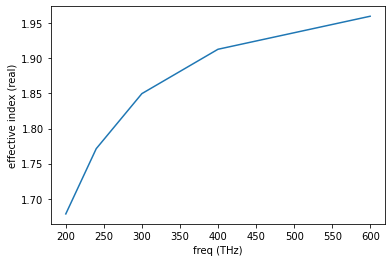

In [18]:
freqs = C_0 / np.linspace(0.5, 1.5, 5)
neffs = []
for freq in freqs:
    mode_solver = ModeSolver(
        simulation=sim,
        plane=plane,
        freq=freq)
    mode_info = mode_solver.solve(mode)
    print(f'freq = {(freq/1e12):.0f} THz\n\t- neff = {mode_info.n_eff:.2f}\n\t- keff = {mode_info.k_eff:.2e}')
    neffs.append(mode_info.n_eff)
    # or, get field data and plot

plt.plot(freqs / 1e12, neffs)
plt.xlabel('freq (THz)')
plt.ylabel('effective index (real)')
plt.show()

### Viewing multiple mode specifications
One might want to view multiple mode specifications side by side, for now, just iterate:

mode index = 0
	- neff = 1.85
	- keff = 1.72e-18


mode index = 1
	- neff = 1.83
	- keff = -5.78e-17


mode index = 2
	- neff = 1.68
	- keff = 9.39e-11


mode index = 3
	- neff = 1.66
	- keff = -1.70e-17


mode index = 4
	- neff = 1.56
	- keff = -7.65e-15


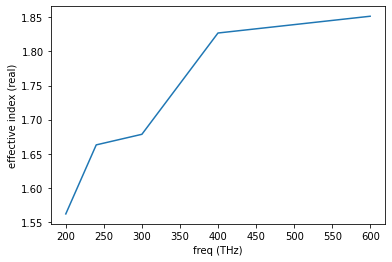

In [19]:
mode_indices = np.arange(0, 5)
mode_solver = ModeSolver(
    simulation=sim,
    plane=plane,
    freq=freq)

neffs = []
for mode_index in mode_indices:
    mode = td.Mode(mode_index=mode_index)
    mode_info = mode_solver.solve(mode)
    print(f'mode index = {mode_index}\n\t- neff = {mode_info.n_eff:.2f}\n\t- keff = {mode_info.k_eff:.2e}')
    neffs.append(mode_info.n_eff)
    # or, get field data and plot

plt.plot(freqs / 1e12, neffs)
plt.xlabel('freq (THz)')
plt.ylabel('effective index (real)')
plt.show()

## Notes / Considerations

- This mode solver runs locally, which means it does not require credits to run.
- It also means that the mode solver does not use subpixel-smoothening, even if this is specified in the simulation.  Therefore, the results might not perfectly match what we compute with `simulation.subpixel=True`.
- Symmetries are applied to the cross section of the permittivity parsed from the simulation.  It uses the upper quadrant data to fill the full `plane`.  